Here we will train the architecture over the original dataset (grayscale MNIST). We want to make sure the encoder + classifier is able to detect the evenness of the numbers, but remains simple enough.

In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import os

from models import Classifier, MLPEncoder, ConvEncoder

import torch
from torchvision.datasets import MNIST
import torch.optim as optim
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F

import matplotlib.pyplot as plt


from sklearn.metrics import classification_report

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(device)

cpu


In [4]:
batch_size = 256

# MNIST Dataset
mnist_trainset = MNIST(root='../data/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = MNIST(root='../data/mnist_data/', train=False, transform=transforms.ToTensor(), download=True)


In [5]:
mnist_trainset.targets = mnist_trainset.targets % 2
mnist_testset.targets = mnist_testset.targets % 2

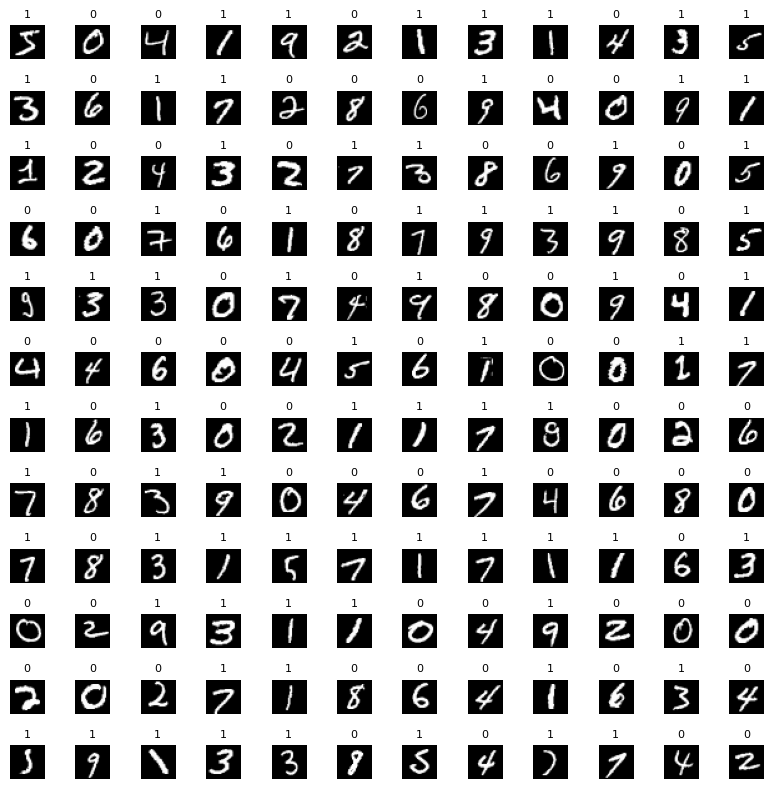

In [6]:
plt.figure(figsize=(8, 8))

for i in range(144):
    img, label = mnist_trainset[i]
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(str(label), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
train_loader = data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

In [8]:
learning_rate = 1e-3
n_epochs = 5

encoder = MLPEncoder(in_dim=28*28*1, latent_dim=1, output_neurons=()).to(device)
#encoder = ConvEncoder(in_channels=1)
classifier = Classifier(latent_dim=1).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

In [9]:
# training loop
for epoch in range(n_epochs):
    encoder.train()
    classifier.train()
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        z = encoder(images)
        outputs = classifier(z)
        loss = criterion(outputs, labels.float())
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} complete: Loss = {loss.item():.6f}")

Epoch 1 complete: Loss = 0.476621
Epoch 2 complete: Loss = 0.350402
Epoch 3 complete: Loss = 0.220649
Epoch 4 complete: Loss = 0.320528
Epoch 5 complete: Loss = 0.208779


In [10]:
all_preds = []
all_labels = []

encoder.eval()
classifier.eval()

with torch.no_grad():
    for images, labels in test_loader:
        z = encoder(images)
        outputs = classifier(z)
        preds = (outputs > 0).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=["Even","Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.90      0.89      4926
         Odd       0.90      0.89      0.90      5074

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [11]:
# MLP
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.90      0.89      4926
         Odd       0.90      0.89      0.90      5074

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [12]:
# convolutional
print(classification_report(all_labels, all_preds, target_names=["Even", "Odd"]))

              precision    recall  f1-score   support

        Even       0.89      0.90      0.89      4926
         Odd       0.90      0.89      0.90      5074

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

